In [1]:
!pip3 install matplotlib numpy sympy
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp

In [2]:
h0 = 0
v0 = 870
L = 1500
k = 1.3 * 10 ** (-5)
m = 13.6 / 1000


In [3]:
a, t = smp.symbols("a, t")

"""
create a system of equations
0 = 0 + v0 sin(a) - gt^2 / 2
L = v sin(a) * t
"""

eq1 = smp.Eq(0, h0 + v0 * smp.sin(a) * t - 9.81 * t ** 2 / 2)
eq2 = smp.Eq(L, v0 * smp.cos(a) * t)

sol = list(filter(lambda s: s[t] > 0 , smp.solve([eq1, eq2], [a, t], dict=True)))

sol

for s in sol:
    hmax = v0 * smp.sin(s[a]) * (s[t] / 2) - 9.81 * (s[t] / 2) ** 2 / 2

    print(f"for sol {s} max height is {hmax}")

for sol {a: 0.00972118318116229, t: 1.72421940096865} max height is 3.64555853045729
for sol {a: 1.56107514361373, t: 177.361649788719} max height is 38574.3360928457


In [4]:
# function will estimate our position at the end with given starting angle for projectile

from scipy.integrate import odeint


def dSdx(S, x):
    vx, vy = S
    return [0, -9.81]


def estimate_xy(angle: float) -> np.array:
    v0x = v0 * np.cos(angle)
    v0y = v0 * np.sin(angle)
    S0 = [v0x, v0y]
    t = np.linspace(0, 200, 10000)
    sol = odeint(dSdx, S0, t)

    # get position
    x = np.cumsum(sol[:, 0]) * (t[1] - t[0])
    y = np.cumsum(sol[:, 1]) * (t[1] - t[0])

    # get time at which we reached x=L, y=0
    curt = np.interp(L, x, t)
    # get index of that time
    i = np.argmin(np.abs(t - curt))
    # get x and y at that time
    x = x[i]
    y = y[i]
    return np.array([x, y])


def position_error(angle: float) -> float:
    x, y = estimate_xy(angle)
    return np.sqrt((x - L) ** 2 + y**2)


# use scipy to optimize position_error

from scipy.optimize import minimize_scalar

res_low = minimize_scalar(position_error, bounds=(0, 0.1), method="bounded", tol=1e-20)
print(res_low)

res_high = minimize_scalar(
    position_error, bounds=(1.5, 1.6), method="bounded", tol=1e-20
)
print(res_high)


     fun: 3.5189373244712856
 message: 'Solution found.'
    nfev: 18
     nit: 18
  status: 0
 success: True
       x: 0.009563100831781782
     fun: 3.4065028518284803
 message: 'Solution found.'
    nfev: 23
     nit: 23
  status: 0
 success: True
       x: 1.5610758107611598


/home/leo/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:870: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [5]:
estimate_xy(res_low.x), estimate_xy(res_high.x)


(array([ 1.49648122e+03, -3.36517635e-02]),
 array([1500.03311244,    3.40634192]))

In [6]:
# function will estimate our position at the end with given starting angle for projectile


from scipy.integrate import odeint

def dSdx(S, x):
    vx, vy = S
    return [
        -k / m * np.sqrt(vx**2 + vy**2) * vx,
        -9.81 - k / m * np.sqrt(vx**2 + vy**2) * vy,
    ]


def estimate_xy(angle: float) -> np.array:
    v0x = v0 * np.cos(angle)
    v0y = v0 * np.sin(angle)
    S0 = [v0x, v0y]
    t = np.linspace(0, 200, 1000000)
    sol = odeint(dSdx, S0, t)

    # get position
    x = np.cumsum(sol[:, 0]) * (t[1] - t[0])
    y = np.cumsum(sol[:, 1]) * (t[1] - t[0])

    # get time at which we reached x=L, y=0
    curt = np.interp(L, x, t)
    # get index of that time
    i = np.argmin(np.abs(t - curt))
    # get x and y at that time
    x = x[i]
    y = y[i]
    return np.array([x, y])


def position_error(angle: float) -> float:
    x, y = estimate_xy(angle)
    return np.sqrt((x - L) ** 2 + y**2)


# use scipy to optimize position_error

from scipy.optimize import minimize_scalar

res_low = minimize_scalar(position_error, bounds=(0, 0.15), method="bounded", tol=1e-20)
print(res_low)

res_high = minimize_scalar(
    position_error, bounds=(1.2, 1.6), method="bounded", tol=1e-30
)
print(res_high)


     fun: 0.015591272699437293
 message: 'Solution found.'
    nfev: 22
     nit: 22
  status: 0
 success: True
       x: 0.03248348942941089
     fun: 15811.358438745445
 message: 'Solution found.'
    nfev: 11
     nit: 11
  status: 0
 success: True
       x: 1.4926250154223633


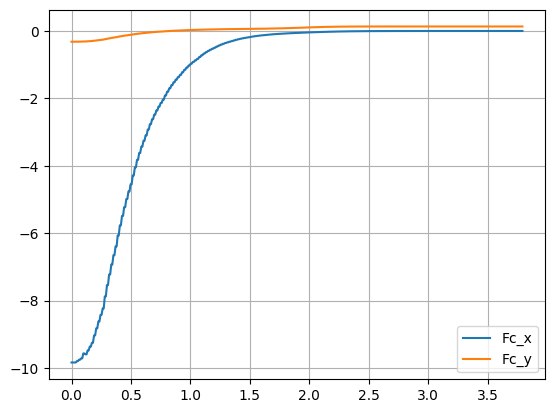

In [7]:
# seems like only res_low will satisfy our requirements

res_angle = res_low.x

# simulate system with such starting angle and store Fc

from scipy.integrate import odeint

forcex = []
forcey = []


def dSdx(S, x):
    vx, vy = S
    res = [
        -k / m * np.sqrt(vx**2 + vy**2) * vx,
        -9.81 - k / m * np.sqrt(vx**2 + vy**2) * vy,
    ]

    forcex.append(-k * np.sqrt(vx**2 + vy**2) * vx)
    forcey.append(-k * np.sqrt(vx**2 + vy**2) * vy)

    return res


def estimate(angle: float) -> np.array:
    v0x = v0 * np.cos(angle)
    v0y = v0 * np.sin(angle)
    S0 = [v0x, v0y]
    t = np.linspace(0, 200, 10000)
    sol = odeint(dSdx, S0, t)

    # get position
    x = np.cumsum(sol[:, 0]) * (t[1] - t[0])
    y = np.cumsum(sol[:, 1]) * (t[1] - t[0])

    # get time at which we reached x=L, y=0
    curt = np.interp(L, x, t)
    # get index of that time
    i = np.argmin(np.abs(t - curt))
    # get x and y at that time
    x = x[i]
    y = y[i]
    return np.array([x, y, curt])


x, y, t = estimate(res_angle)

# plot Fc

import matplotlib.pyplot as plt

# set matplotlib style
plt.grid()

plt.plot(np.linspace(0, t, len(forcex)), forcex, label="Fc_x")
plt.plot(np.linspace(0, t, len(forcey)), forcey, label="Fc_y")

plt.legend()
plt.show()
